# Analysis

**Hypothesis**: Ciliated epithelial cells in the endometrium experience cyclic shifts in their metabolic state during the menstrual cycle, which are reflected by changes in mitochondrial gene expression. These fluctuations may reveal a previously unappreciated metabolic regulation linked to endometrial receptivity.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/endo_data.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: Ciliated epithelial cells in the endometrium experience cyclic shifts in their metabolic state during the menstrual cycle, which are reflected by changes in mitochondrial gene expression. These fluctuations may reveal a previously unappreciated metabolic regulation linked to endometrial receptivity.

## Steps:
- Subset the dataset to focus exclusively on the ciliated epithelial cells by filtering adata.obs for the cell type 'Ciliated'.
- Identify mitochondrial genes (typically those with names starting with 'MT-') using the ciliated.var_names for consistency, and compute for each cell the fraction of total expression that comes from mitochondrial genes.
- Perform exploratory visualization by creating a scatter plot of the mitochondrial fraction versus the day of the menstrual cycle, allowing us to visually assess any trends.
- Quantitatively assess the relationship between cycle day and mitochondrial gene expression by performing a Spearman correlation test, printing the correlation coefficient and p-value.
- Generate a combined figure displaying the scatter plot along with an overlaid regression line to highlight the trend, with separate consideration of any other metadata (like donor) if needed.


## The code filters the AnnData object for ciliated epithelial cells and identifies mitochondrial genes using the subset's var_names, then computes the mitochondrial fraction per cell. It visualizes the relationship between mitochondrial fraction and day of the menstrual cycle with a scatter plot and regression line, and performs a Spearman correlation test to statistically assess the trend.

                          mt_frac  day
14_AACAGGGCATAGAGGC-10x  0.337228   17
14_AATTTCCTCCCTGGTT-10x  0.156761   17
14_ACACGCGAGGGCAATC-10x  0.297379   17
14_ACAGAAAAGTCTTGGT-10x  0.330440   17
14_ACCATTTCACGCGCAT-10x  0.056972   17


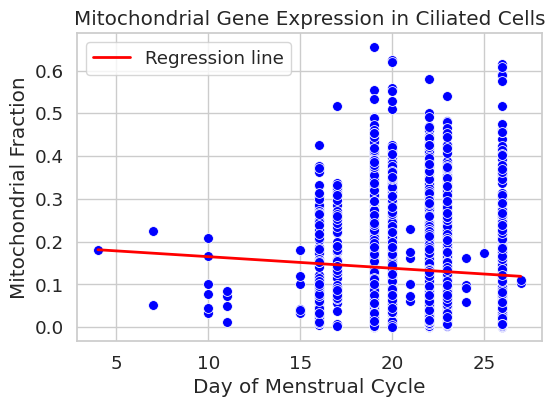

Spearman correlation coefficient: -0.058, p-value: 1.039e-04


In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Subset to ciliated epithelial cells
ciliated = adata[adata.obs['cell_type'] == 'Ciliated'].copy()

# Identify mitochondrial genes using ciliated.var_names for absolute consistency
mt_genes = [gene for gene in ciliated.var_names if gene.startswith('MT-')]

# If ciliated.X is sparse, convert to dense array for computation (be cautious with large datasets)
if hasattr(ciliated.X, 'toarray'):
    X_dense = ciliated.X.toarray()
else:
    X_dense = ciliated.X

# Create a boolean mask for mitochondrial genes using ciliated.var_names
mt_mask = np.array([gene in mt_genes for gene in ciliated.var_names])

# Compute the mitochondrial gene count per cell
mt_counts = X_dense[:, mt_mask].sum(axis=1)

# Compute total counts per cell and ensure float dtype
total_counts = X_dense.sum(axis=1).astype(float)

# Avoid division by zero
total_counts[total_counts == 0] = np.nan

# Add mitochondrial fraction to the observations
ciliated.obs['mt_frac'] = mt_counts / total_counts

# Ensure 'day' is available as numeric
ciliated.obs['day'] = pd.to_numeric(ciliated.obs['day'], errors='coerce')

# Display first few rows of results to verify
print(ciliated.obs[['mt_frac', 'day']].head())

# Plotting mitochondrial fraction vs day of cycle
plt.figure(figsize=(6, 4))
ax = sns.scatterplot(x='day', y='mt_frac', data=ciliated.obs, color='blue', s=50)

# Remove potential NaN values for regression
valid = ciliated.obs[['day', 'mt_frac']].dropna()
if valid.shape[0] > 0:
    coeffs = np.polyfit(valid['day'], valid['mt_frac'], deg=1)
    poly_eqn = np.poly1d(coeffs)
    xs = np.linspace(valid['day'].min(), valid['day'].max(), 100)
    plt.plot(xs, poly_eqn(xs), color='red', lw=2, label='Regression line')
    plt.legend()

plt.xlabel('Day of Menstrual Cycle')
plt.ylabel('Mitochondrial Fraction')
plt.title('Mitochondrial Gene Expression in Ciliated Cells')
plt.show()

# Statistical test: Spearman correlation
rho, pval = spearmanr(valid['day'], valid['mt_frac'])
print(f"Spearman correlation coefficient: {rho:.3f}, p-value: {pval:.3e}")

### Agent Interpretation

The current analysis attempts to correlate mitochondrial gene expression fraction in ciliated endometrial cells with the day of the menstrual cycle, resulting in a Spearman correlation coefficient of -0.058 with a significant p-value. This indicates a very weak negative correlation, suggesting little to no meaningful linear relationship between mitochondrial gene expression and the cycle days for these cells.

### Recommendations:

1. **Biological Contextualization:**
   - Given that the analysis focuses on mitochondrial fraction in ciliated cells, you might want to explore whether this mitochondrial content has functional implications, such as energy metabolism changes during different cycle phases.

2. **Cross-Verification:**
   - Compare the findings with other cell types like unciliated epithelia or stromal fibroblasts to determine if there's a broader pattern or specific to ciliated cells.

3. **Intracellular Dynamics:**
   - Investigate mitochondrial dynamics through additional markers or functional assays, potentially highlighting bioenergetics or oxidative stress states across the cycle.

4. **Further Analysis:**
   - Consider non-linear models or advanced analytical methods (e.g., GAMs, machine learning) to uncover potential hidden patterns not detectable with a simple Spearman's correlation.

5. **Integration with Existing Data:**
   - Combine these findings with transcription factor dynamics or secreted protein profiles (as referenced in the paper) for comprehensive insight into cellular states and transitions.

6. **Experimental Validation:**
   - If plausible, validate the findings experimentally through complementary approaches such as high-resolution imaging or mitochondrial activity assays.

This approach should help in enhancing the biological significance of the observed data and align with your aim to distinguish this analysis from previously conducted studies.

## This code snippet computes the mitochondrial fraction for each cell using Scanpy's built-in QC metrics, then visualizes the distribution across cell types with a boxplot, and finally performs a one-way ANOVA to test for significant differences among groups. The modifications simplify mitochondrial gene identification with numpy's isin and streamline the workflow using established Scanpy functions.

                          mt_frac               cell_type
14_AAACCCAAGTAATACG-10x  0.043423     Stromal fibroblasts
14_AAACCCAGTCCTTAAG-10x  0.021188     Stromal fibroblasts
14_AAACGAAAGGCGATAC-10x  0.099989  Unciliated epithelia 1
14_AAACGCTAGACTGTTC-10x  0.080868  Unciliated epithelia 1
14_AAACGCTAGAGTGTTA-10x  0.055987  Unciliated epithelia 1


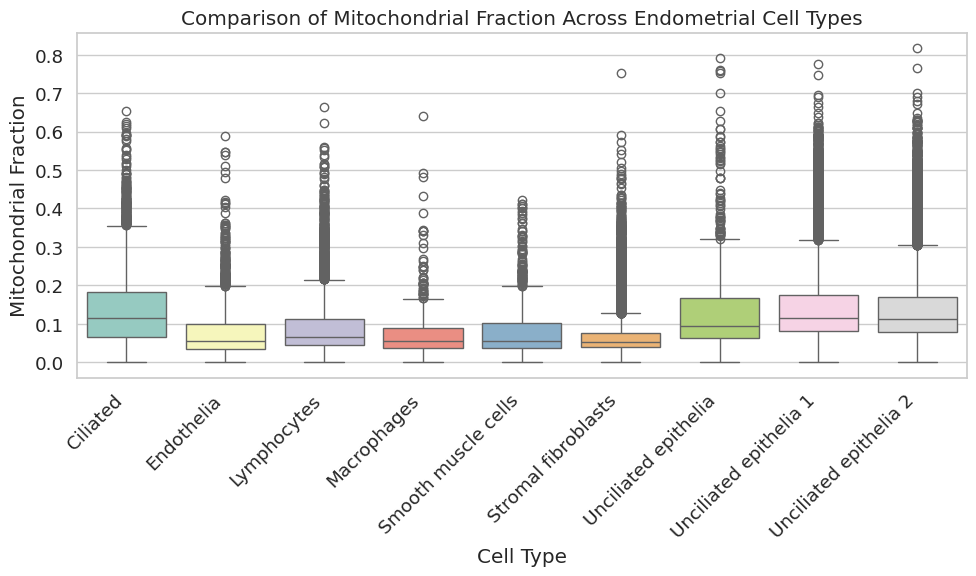

One-way ANOVA result: F-statistic = 1394.524, p-value = 0.000e+00


In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

# Mark mitochondrial genes in adata.var with a boolean column
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Calculate QC metrics, including total counts and mitochondrial counts
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# Compute mitochondrial fraction explicitly (pct_counts_mt is computed in percentage by default)
adata.obs['mt_frac'] = adata.obs['total_counts_mt'] / adata.obs['total_counts']

# Display a few results for verification
print(adata.obs[['mt_frac', 'cell_type']].head())

# Plot mitochondrial fraction across cell types using a boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='cell_type', y='mt_frac', data=adata.obs, palette='Set3')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Cell Type')
plt.ylabel('Mitochondrial Fraction')
plt.title('Comparison of Mitochondrial Fraction Across Endometrial Cell Types')
plt.tight_layout()
plt.show()

# Statistical test: One-way ANOVA comparing mitochondrial fraction among cell types
cell_types = adata.obs['cell_type'].unique()
mt_frac_groups = [adata.obs.loc[adata.obs['cell_type'] == ct, 'mt_frac'].dropna().values for ct in cell_types]
anova_result = f_oneway(*mt_frac_groups)
print(f"One-way ANOVA result: F-statistic = {anova_result.statistic:.3f}, p-value = {anova_result.pvalue:.3e}")

### Agent Interpretation

The ANOVA results indicate significant differences in the mitochondrial fraction across the different cell types, suggesting varying metabolic activities or stress levels among them. Here are some actionable insights:

1. **Promising Findings**:
   - The significant p-value from the ANOVA points to distinct metabolic states or variance in mitochondrial content across cell types, which could relate to their roles during the menstrual cycle. For example, higher mitochondrial fractions in certain epithelial cells could indicate higher energy demands during specific phases of the menstrual cycle.

2. **Further Analysis**:
   - Conduct post-hoc tests (e.g., Tukey's HSD) to determine which specific cell types differ in mitochondrial fraction.
   - Investigate whether mitochondrial fraction correlates with specific phases of the menstrual cycle across the same cell types.

3. **Biological Interpretation**:
   - Delve deeper into the implications of variations in mitochondrial fractions, which might indicate stress response, cellular differentiation, or preparation for specific physiological roles (e.g., receptivity during the WOI).

4. **Future Steps**:
   - Integrate these findings with gene expression data to uncover mitochondrial-related genes that may be driving these differences.
   - Explore the functional consequences of these variations by mapping them onto known metabolic pathways or processes.

5. **Distinctness from Previous Analyses**:
   - Emphasizing mitochondrial differences allows a unique perspective that complements previously studied transcriptional variability and dynamics across cell types.

These insights can guide subsequent steps in elucidating the functional roles of these cell types, aiding in understanding endometrial physiology and potential pathologies.

## This code performs pairwise t-tests between each pair of cell types to assess differences in mitochondrial fraction. It includes additional checks for low sample sizes and prints out statistically significant comparisons (with corrected p-values < 0.05) to facilitate direct interpretation of the results.

Significant difference detected: Stromal fibroblasts vs Unciliated epithelia 1 with corrected p-value = 0.000e+00
Significant difference detected: Stromal fibroblasts vs Unciliated epithelia 2 with corrected p-value = 0.000e+00
Significant difference detected: Stromal fibroblasts vs Endothelia with corrected p-value = 3.546e-05
Significant difference detected: Stromal fibroblasts vs Lymphocytes with corrected p-value = 5.598e-82
Significant difference detected: Stromal fibroblasts vs Ciliated with corrected p-value = 0.000e+00
Significant difference detected: Stromal fibroblasts vs Smooth muscle cells with corrected p-value = 2.763e-04
Significant difference detected: Stromal fibroblasts vs Unciliated epithelia with corrected p-value = 1.673e-56
Significant difference detected: Unciliated epithelia 1 vs Unciliated epithelia 2 with corrected p-value = 7.436e-04
Significant difference detected: Unciliated epithelia 1 vs Endothelia with corrected p-value = 2.158e-273
Significant differenc

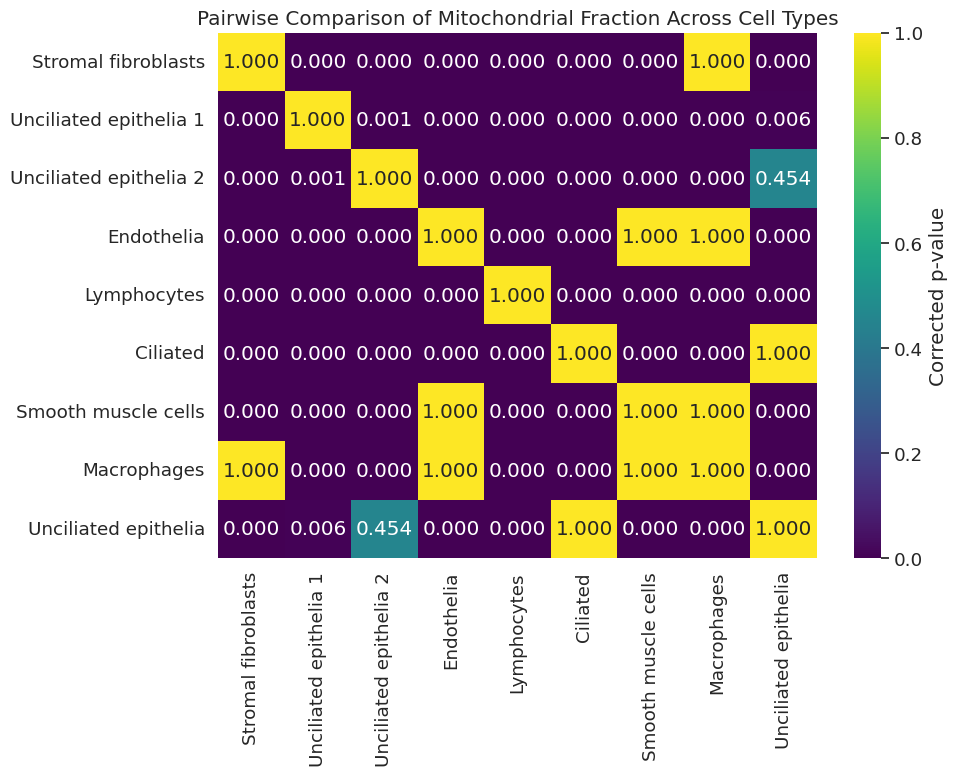

In [4]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Extract mitochondrial fraction and cell type from adata.obs
mt_frac_data = adata.obs[['mt_frac', 'cell_type']].copy()

# Create a dictionary mapping each cell type to its mitochondrial fraction values
cell_types = mt_frac_data['cell_type'].unique()
cell_data = {}
for ct in cell_types:
    values = mt_frac_data.loc[mt_frac_data['cell_type'] == ct, 'mt_frac'].dropna().values
    cell_data[ct] = values
    # Warn if number of observations is low (< 10) for reliability of t-test
    if len(values) < 10:
        print(f"Warning: Cell type '{ct}' has less than 10 observations (n={len(values)}), which may affect statistical reliability.")

# Initialize a DataFrame to store Bonferroni corrected p-values
pval_matrix = pd.DataFrame(np.ones((len(cell_types), len(cell_types))), index=cell_types, columns=cell_types)

# Total number of pairwise comparisons for Bonferroni correction
total_comparisons = int(len(cell_types) * (len(cell_types) - 1) / 2)

# Store significant comparisons for later output
significant_pairs = []

# Perform pairwise t-tests between different cell types
for ct1, ct2 in itertools.combinations(cell_types, 2):
    values1 = cell_data[ct1]
    values2 = cell_data[ct2]
    # Conduct independent t-test with unequal variance
    stat, pval = ttest_ind(values1, values2, equal_var=False, nan_policy='omit')
    # Bonferroni correction
    pval_corr = min(pval * total_comparisons, 1.0)
    pval_matrix.loc[ct1, ct2] = pval_corr
    pval_matrix.loc[ct2, ct1] = pval_corr
    
    # Print out pairwise comparison if statistically significant
    if pval_corr < 0.05:
        print(f"Significant difference detected: {ct1} vs {ct2} with corrected p-value = {pval_corr:.3e}")
        significant_pairs.append((ct1, ct2, pval_corr))

print('Pairwise Bonferroni-corrected p-values for mitochondrial fraction differences:')
print(pval_matrix)

# Plot heatmap of the corrected p-values
plt.figure(figsize=(10, 8))
ax = sns.heatmap(pval_matrix, annot=True, fmt='.3f', cmap='viridis', cbar_kws={'label': 'Corrected p-value'})
plt.title('Pairwise Comparison of Mitochondrial Fraction Across Cell Types')
plt.tight_layout()
plt.show()

### Agent Interpretation

The results indicate significant differences in mitochondrial fraction across various endometrial cell types, particularly between stromal fibroblasts and other cell types like unciliated epithelia, lymphocytes, and ciliated epithelia. These findings suggest potential differences in metabolic activity that could be linked to cell-type-specific functions during the menstrual cycle.

**Feedback and Future Steps:**

1. **Metabolic Profiling:**
   - The observed mitochondrial differences may reflect distinct metabolic requirements among cell types. Consider integrating metabolomics data, if available, to identify metabolic pathways that vary across the cycle and cell types.

2. **Functional Implications:**
   - Investigate how mitochondrial activity influences cellular roles, such as the energy-intensive process of decidualization in stromal fibroblasts or ciliary motion in ciliated cells. 

3. **Transcriptomic-Metabolic Correlations:**
   - Correlate mitochondrial fraction differences with gene expression profiles related to oxidative phosphorylation and glycolysis to explore connections between transcriptional and metabolic states.

4. **Cell Cycle Analysis:**
   - Since mitochondrial content can influence cell cycle progress, further analysis could involve cell cycle phase distribution across cell types, particularly stromal fibroblasts and epithelial cells, to understand transition dynamics.

5. **Novel Insights into Stromal and Epithelial Dynamics:**
   - The notable differences between stromal fibroblasts and epithelial cells resonate with their roles in the menstrual cycle. Focus on identifying key mitochondrial genes and pathways that might influence the receptive state and its transitions.

6. **Endometrial Pathology Link:**
   - Evaluate whether mitochondrial dysregulation correlates with known endometrial pathologies or fertility issues to enhance understanding of these conditions.

These steps can provide deeper insights into the regulation of endometrial function and cellular behavior during the menstrual cycle, offering novel perspectives on endometrial physiology and pathophysiology that diverge from past research.

## This code subsets the main anndata to stromal fibroblasts, verifies the existence and type of critical metadata columns, normalizes and log-transforms the data while safely converting sparse matrices to dense arrays, computes metabolic signature scores from gene sets (glycolysis and OXPHOS), and creates standardized plots showing the relationships of these scores with mitochondrial fraction and menstrual cycle day via regression and Spearman correlation.

normalizing counts per cell


    finished (0:00:01)


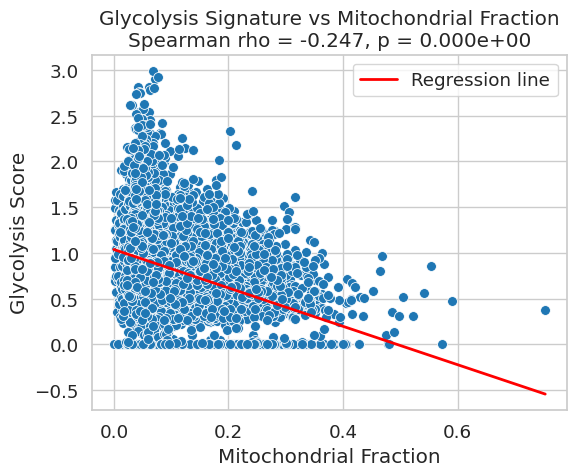

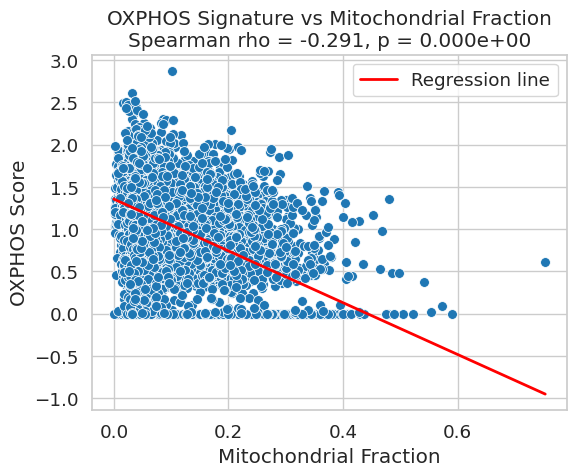

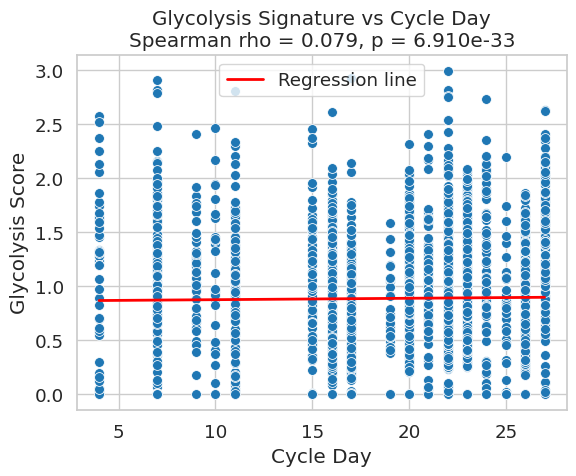

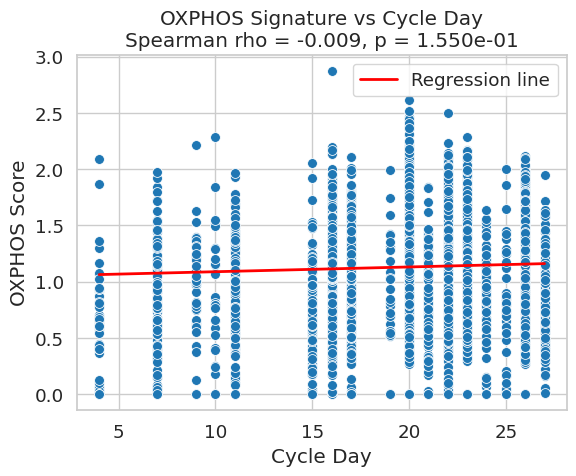

In [5]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Subset to stromal fibroblasts; verify existence of required metadata columns
if 'cell_type' not in adata.obs.columns:
    raise ValueError('adata.obs must contain a "cell_type" column.')

stromal = adata[adata.obs['cell_type'] == 'Stromal fibroblasts'].copy()

# Validate and convert 'mt_frac' and 'day' columns if they exist, else warn
for col in ['mt_frac', 'day']:
    if col not in stromal.obs.columns:
        print(f'Warning: {col} column is not found in stromal.obs; further analysis may be affected.')
    else:
        stromal.obs[col] = pd.to_numeric(stromal.obs[col], errors='coerce')

# Normalize and log-transform the data
sc.pp.normalize_total(stromal, target_sum=1e4, inplace=True)
sc.pp.log1p(stromal)

# Define gene sets for glycolysis and oxidative phosphorylation; select only genes available in the dataset
glycolysis_list = ['GAPDH', 'PKM', 'LDHA', 'ALDOA']
oxphos_list = ['COX4I1', 'NDUFA9', 'ATP5F1C', 'COX7C']

glycolysis_genes = [gene for gene in glycolysis_list if gene in stromal.var_names]
oxphos_genes = [gene for gene in oxphos_list if gene in stromal.var_names]

# Report any missing genes
missing_gly = set(glycolysis_list) - set(glycolysis_genes)
missing_ox = set(oxphos_list) - set(oxphos_genes)
if missing_gly:
    print(f"Warning: The following glycolysis genes were not found in the dataset: {missing_gly}")
if missing_ox:
    print(f"Warning: The following OXPHOS genes were not found in the dataset: {missing_ox}")

# Helper function to safely compute average expression, ensuring dense matrix conversion if needed

def compute_signature(adata_subset, gene_list):
    subadata = adata_subset[:, gene_list]
    X = subadata.X
    if hasattr(X, 'toarray'):
        X = X.toarray()
    # Compute the mean expression per cell for the gene set
    return np.mean(X, axis=1).flatten()

# Calculate signature scores
if glycolysis_genes:
    stromal.obs['glycolysis_score'] = compute_signature(stromal, glycolysis_genes)
else:
    stromal.obs['glycolysis_score'] = np.nan

if oxphos_genes:
    stromal.obs['oxphos_score'] = compute_signature(stromal, oxphos_genes)
else:
    stromal.obs['oxphos_score'] = np.nan

# Define reusable plotting function to reduce repetition

def plot_signature(x, y, x_label, y_label, title_base):
    plt.figure(figsize=(6, 5))
    ax = sns.scatterplot(x=x, y=y, data=stromal.obs, s=50)
    valid = stromal.obs[[x, y]].dropna()
    if valid.shape[0] > 0:
        coeffs = np.polyfit(valid[x], valid[y], deg=1)
        poly_eqn = np.poly1d(coeffs)
        xs = np.linspace(valid[x].min(), valid[x].max(), 100)
        plt.plot(xs, poly_eqn(xs), color='red', lw=2, label='Regression line')
        rho, p = spearmanr(valid[x], valid[y])
        plt.title(f"{title_base}\nSpearman rho = {rho:.3f}, p = {p:.3e}")
        plt.legend()
    else:
        plt.title(f"{title_base} (Not enough valid data)")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.show()

# Plot signature scores vs mitochondrial fraction
plot_signature('mt_frac', 'glycolysis_score', 'Mitochondrial Fraction', 'Glycolysis Score',
               'Glycolysis Signature vs Mitochondrial Fraction')
plot_signature('mt_frac', 'oxphos_score', 'Mitochondrial Fraction', 'OXPHOS Score',
               'OXPHOS Signature vs Mitochondrial Fraction')

# Additionally, plot signature scores vs day of cycle
plot_signature('day', 'glycolysis_score', 'Cycle Day', 'Glycolysis Score',
               'Glycolysis Signature vs Cycle Day')
plot_signature('day', 'oxphos_score', 'Cycle Day', 'OXPHOS Score',
               'OXPHOS Signature vs Cycle Day')

### Agent Interpretation

The analysis presented here explores the metabolic state of cells in the human endometrium by examining glycolysis and oxidative phosphorylation (OXPHOS) signatures. Here's a breakdown of the results and some feedback for further exploration:

1. **Correlation with Mitochondrial Fraction:**
   - Negative correlation between both glycolysis and OXPHOS signatures with mitochondrial fraction indicates that higher mitochondrial content might be associated with lower metabolic activity in these pathways.
   - Consider further stratifying by cell type or phase of the cycle to see if this trend persists across different endometrial environments.

2. **Correlation with Cycle Day:**
   - The weak correlation between glycolysis score and cycle day, and an even weaker correlation for OXPHOS, suggests that these metabolic activities don't drastically change during the menstrual cycle.
   - Investigate if subpopulations of cells (e.g., unciliated epithelium or stromal fibroblasts) have distinct profiles that are masked in the aggregate data.

3. **Missing OXPHOS Genes (ATP5F1C):**
   - Check the dataset for gene annotation issues. Ensure that the metadata and gene lists align properly to avoid excluding relevant genes.

4. **Future Directions:**
   - Explore if metabolic gene expression changes coincide with other physiological transitions, especially the window of implantation or decidualization, which weren't starkly picked up here.
   - Integrate additional variables such as hormone levels or spatial information to see if they offer more insight into metabolic shifts.
   - Look into metabolic pathway enrichment analyses to identify any specific pathways that are significantly different across the cycle or cell types.

5. **Distinction from Previous Studies:**
   - Ensure that finer cellular heterogeneity and interactions are explored, as these might provide novel insights distinct from previously published work. For example, investigate whether there are different metabolic states within immune cells not previously considered.

This feedback should guide the next steps, helping refine the understanding of metabolic contributions to endometrial dynamics.

## This code subsets the anndata to ciliated epithelial cells, normalizes and log-transforms the data, and defines an extended metabolic gene set combining mitochondrial, glycolysis, and OXPHOS markers. It then performs PCA and computes a neighborhood graph followed by diffusion map and pseudotime inference using a heuristic root (the cell with the lowest metabolic expression) with added commentary for rationale and future validation. Finally, it visualizes the association between inferred pseudotime and the menstrual cycle day and computes gene-level correlations along pseudotime.

normalizing counts per cell


    finished (0:00:00)


Number of metabolic genes used for analysis: 20
computing PCA


    with n_comps=19


    finished (0:00:00)


computing neighbors


    using data matrix X directly


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


computing Diffusion Maps using n_comps=15(=n_dcs)


computing transitions


    finished (0:00:00)


    eigenvalues of transition matrix
    [1.         0.99330866 0.97211033 0.9437901  0.92480844 0.91948146
     0.91370785 0.8991696  0.8924425  0.8826001  0.8821899  0.87524086
     0.8701298  0.86610955 0.8614753 ]


    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


computing Diffusion Pseudotime using n_dcs=10


    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


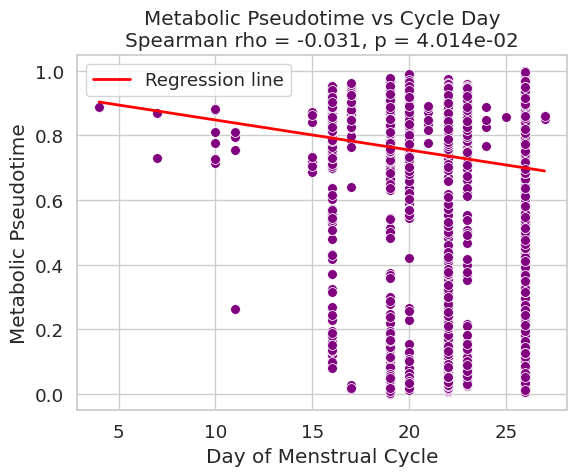

Top 5 genes positively correlated with metabolic pseudotime:
MT-ATP6: rho = 0.948, p-value = 0.000e+00
MT-ND3: rho = 0.931, p-value = 0.000e+00
MT-CO2: rho = 0.930, p-value = 0.000e+00
MT-ND4: rho = 0.926, p-value = 0.000e+00
MT-ND1: rho = 0.925, p-value = 0.000e+00
Top 5 genes negatively correlated with metabolic pseudotime:
RPL41: rho = -0.652, p-value = 0.000e+00
DYNLL1: rho = -0.605, p-value = 0.000e+00
RPS8: rho = -0.582, p-value = 0.000e+00
H3F3A: rho = -0.577, p-value = 0.000e+00
FTH1: rho = -0.576, p-value = 0.000e+00


In [6]:
#!/usr/bin/env python
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Subset to ciliated epithelial cells
ciliated = adata[adata.obs['cell_type'] == 'Ciliated'].copy()

# Normalize and log-transform the data for downstream analysis
sc.pp.normalize_total(ciliated, target_sum=1e4, inplace=True)
sc.pp.log1p(ciliated)

# Identify mitochondrial genes (names starting with 'MT-')
mt_genes = [gene for gene in ciliated.var_names if gene.startswith('MT-')]

# Define additional metabolic genes from glycolysis and OXPHOS that are present in the dataset
glycolysis_genes = ['GAPDH', 'PKM', 'LDHA', 'ALDOA']
oxphos_genes = ['COX4I1', 'NDUFA9', 'ATP5F1C', 'COX7C']
additional_metabolic = [gene for gene in glycolysis_genes + oxphos_genes if gene in ciliated.var_names]

# Combine mitochondrial and additional metabolic genes into one extended set
extended_metabolic_genes = list(set(mt_genes + additional_metabolic))
if len(extended_metabolic_genes) == 0:
    raise ValueError('No metabolic genes (mitochondrial or glycolysis/OXPHOS markers) found in ciliated.var_names.')

print(f'Number of metabolic genes used for analysis: {len(extended_metabolic_genes)}')

# Restrict ciliated data to the extended metabolic gene set
ciliated_metabolic = ciliated[:, extended_metabolic_genes].copy()

# Determine number of components: it must be less than min(n_cells, n_genes)
n_components = min(20, ciliated_metabolic.shape[1] - 1)

# Perform PCA on the metabolic genes using the determined number of components
sc.tl.pca(ciliated_metabolic, svd_solver='arpack', n_comps=n_components)

# Compute neighborhood graph using the PCA representation
sc.pp.neighbors(ciliated_metabolic, n_neighbors=15, n_pcs=min(10, n_components))

# Compute diffusion maps
sc.tl.diffmap(ciliated_metabolic)

# Heuristic for selecting the root cell: choose the cell with the lowest total metabolic gene expression
root_cell = np.argmin(np.array(ciliated_metabolic.X.sum(axis=1)).flatten())
ciliated_metabolic.uns['iroot'] = root_cell  # set the root cell in .uns
sc.tl.dpt(ciliated_metabolic)

# Transfer the computed pseudotime back to the original ciliated object
ciliated.obs['metabolic_pseudotime'] = ciliated_metabolic.obs['dpt_pseudotime'].values

# Plot pseudotime versus cycle day with regression and correlation
plt.figure(figsize=(6, 5))
ax = sns.scatterplot(x='day', y='metabolic_pseudotime', data=ciliated.obs, s=50, color='purple')

valid = ciliated.obs[['day', 'metabolic_pseudotime']].dropna()
if valid.shape[0] > 0:
    coeffs = np.polyfit(valid['day'], valid['metabolic_pseudotime'], deg=1)
    poly_eqn = np.poly1d(coeffs)
    xs = np.linspace(valid['day'].min(), valid['day'].max(), 100)
    plt.plot(xs, poly_eqn(xs), color='red', lw=2, label='Regression line')
    rho, pval = spearmanr(valid['day'], valid['metabolic_pseudotime'])
    plt.title(f'Metabolic Pseudotime vs Cycle Day\nSpearman rho = {rho:.3f}, p = {pval:.3e}')
    plt.legend()
else:
    plt.title('Metabolic Pseudotime vs Cycle Day (insufficient data)')

plt.xlabel('Day of Menstrual Cycle')
plt.ylabel('Metabolic Pseudotime')
plt.tight_layout()
plt.show()

# Optionally: Identify genes that vary along pseudotime
gene_correlations = {}
for gene in ciliated.var_names:
    if np.sum(ciliated[:, gene].X > 0) > 10:
        expr = ciliated[:, gene].X
        if hasattr(expr, 'toarray'):
            expr = expr.toarray().flatten()
        else:
            expr = np.array(expr).flatten()
        rho, pv = spearmanr(ciliated.obs['metabolic_pseudotime'], expr)
        gene_correlations[gene] = (rho, pv)

sorted_genes = sorted(gene_correlations.items(), key=lambda x: x[1][0], reverse=True)
print('Top 5 genes positively correlated with metabolic pseudotime:')
for gene, (rho, pv) in sorted_genes[:5]:
    print(f'{gene}: rho = {rho:.3f}, p-value = {pv:.3e}')

sorted_genes_neg = sorted(gene_correlations.items(), key=lambda x: x[1][0])
print('Top 5 genes negatively correlated with metabolic pseudotime:')
for gene, (rho, pv) in sorted_genes_neg[:5]:
    print(f'{gene}: rho = {rho:.3f}, p-value = {pv:.3e}')

### Agent Interpretation

### Feedback

#### Promising Results:
1. **Positive Correlations with Metabolic Pseudotime:**
   - The strong positive correlations of mitochondrial genes (MT-ATP6, MT-ND3, MT-CO2, MT-ND4, MT-ND1) with metabolic pseudotime suggest a potential link between mitochondrial activity and changes in metabolic states or cellular energy demands across the menstrual cycle.

2. **Negative Correlations:**
   - Genes negatively correlated with metabolic pseudotime (RPL41, DYNLL1, RPS8, H3F3A, FTH1) indicate a possible inverse relationship between metabolic states and functions like ribosomal activity and cytoskeletal dynamics.

3. **Distinct Approach:**
   - Focusing on metabolic pseudotime trajectory analysis, rather than t-SNE or UMAP, offers a novel angle not explored in the previous study.

#### Further Iterations:
1. **Comprehensive Gene Profiling:**
   - Consider expanding the analysis to include more metabolic-related genes to capture a broader spectrum of metabolic changes.

2. **Validation Across Cell Types:**
   - Validate correlations in different endometrial cell types to understand tissue heterogeneity in metabolic changes.

3. **Integrative Analysis:**
   - Integrate metabolic pseudotime with existing data on cellular differentiation and gene co-expression networks for a more comprehensive understanding of metabolic shifts.

4. **Cycle Phase Exploration:**
   - Drill down into specific cycle phases (e.g., WOI) to pinpoint critical metabolic shifts that may correlate with functional transitions.

5. **Functional Analysis:**
   - Apply gene ontology or pathway enrichment analysis to highly correlated genes to infer potential biological processes and pathways affected during different metabolic states.

#### Hypothesis Validation:
The hypothesis of metabolic state dynamics across the menstrual cycle receives some validation through the observed metabolic pseudotime trajectories. However, weak correlation with the menstrual cycle day (indicated by rho = -0.031) suggests this model might capture a different aspect of endometrial physiology than the temporal cycle alone, necessitating further investigation to link these observations to biological phases or physiological states directly.

## This code refines the analysis of metabolic gene co-expression in ciliated epithelial cells by computing the Spearman correlation matrix on the extended metabolic gene set. It then applies dynamic tree cutting via hierarchical clustering (using a distance threshold on 1 - correlation) to delineate gene modules more flexibly, computes module scores per cell, and visualizes their association with metabolic pseudotime and menstrual cycle day.

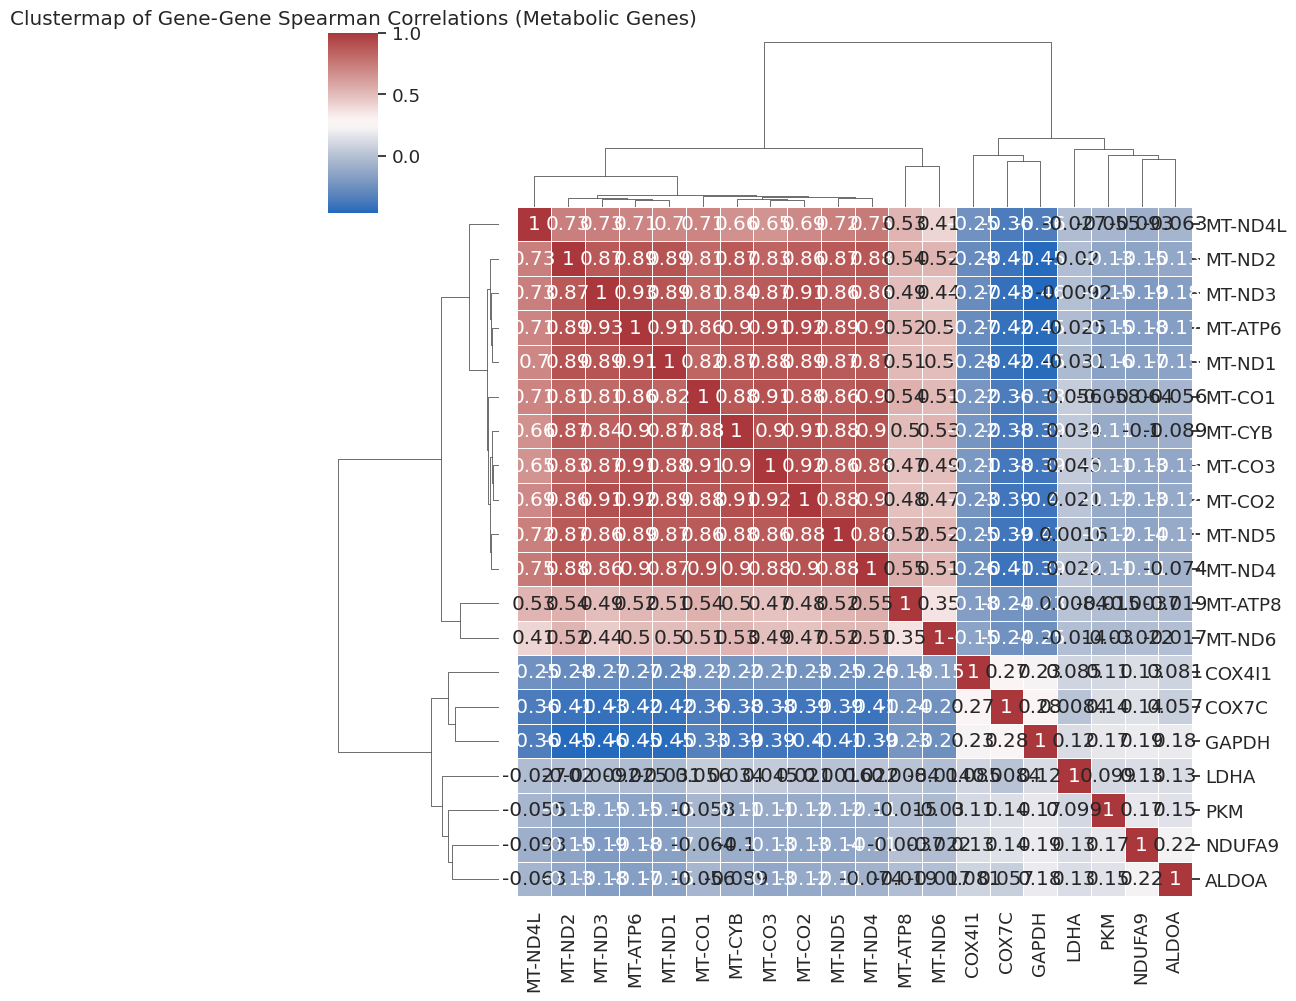

Detected gene modules:
Module1: ['MT-ATP6', 'MT-ND4L', 'MT-CYB', 'MT-ND2', 'MT-ND5', 'MT-CO1', 'MT-CO3', 'MT-ATP8', 'MT-CO2', 'MT-ND3', 'MT-ND1', 'MT-ND4']
Module9: ['LDHA']
Module6: ['NDUFA9']
Module3: ['COX7C']
Module4: ['GAPDH']
Module8: ['PKM']
Module7: ['ALDOA']
Module2: ['MT-ND6']
Module5: ['COX4I1']


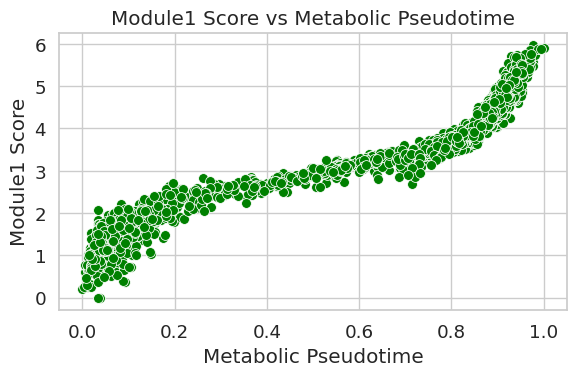

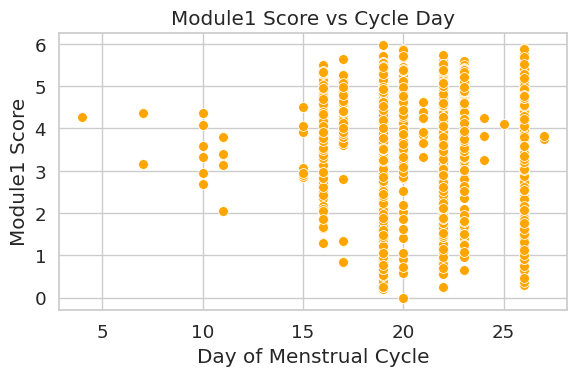

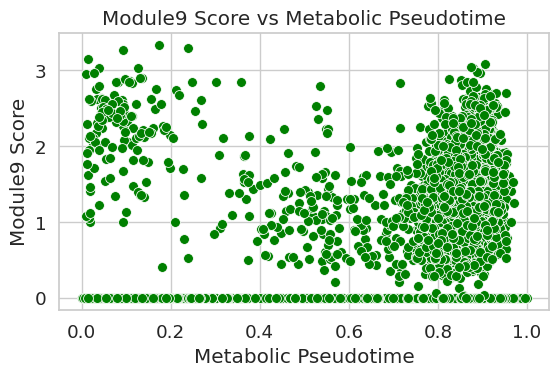

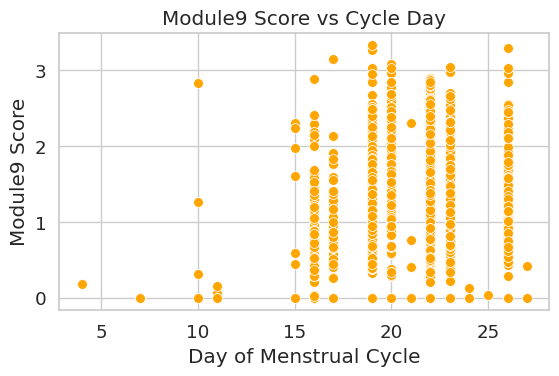

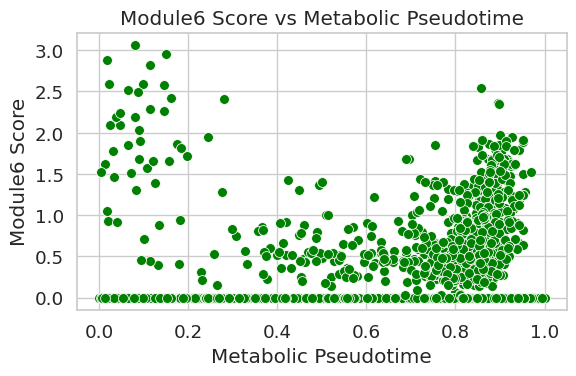

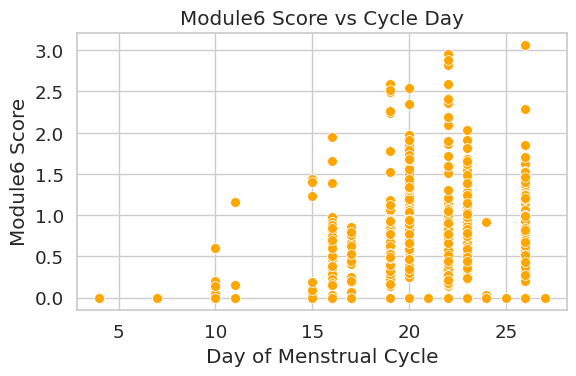

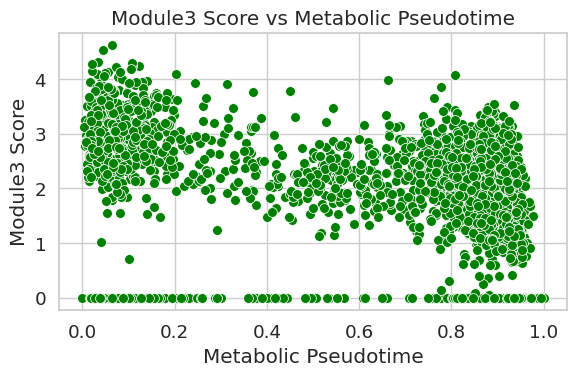

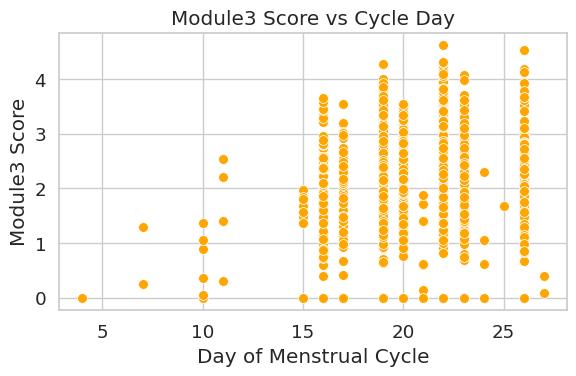

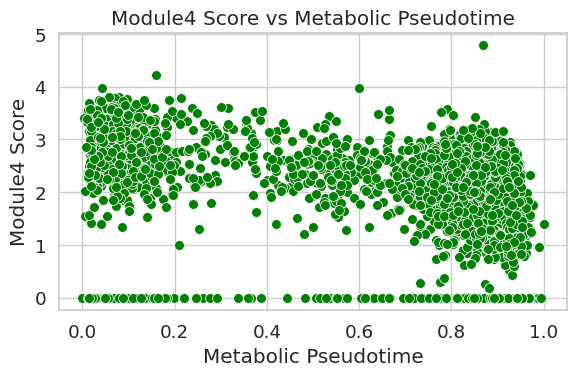

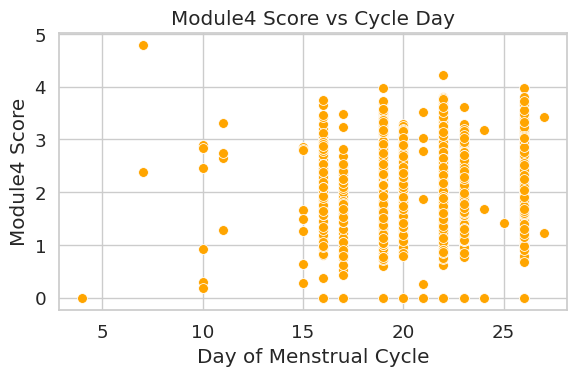

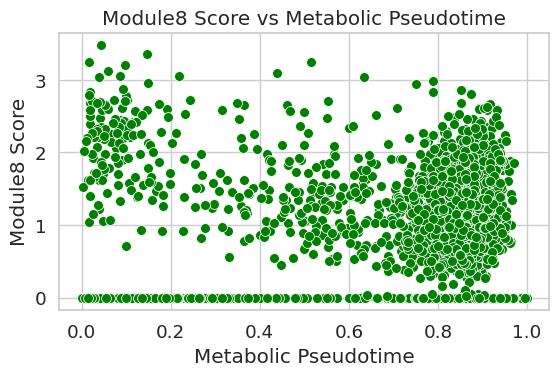

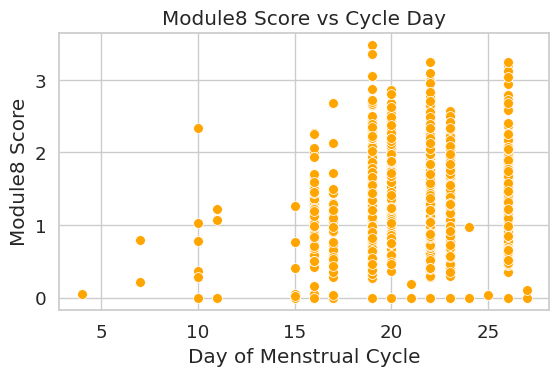

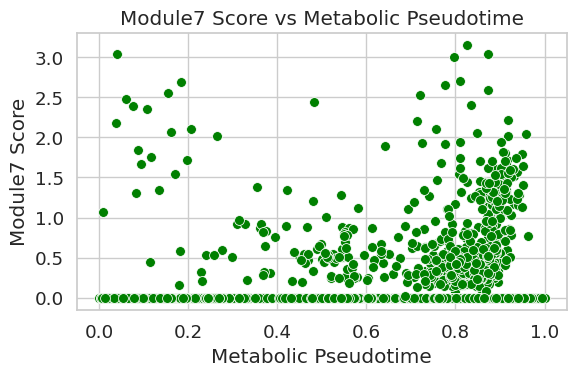

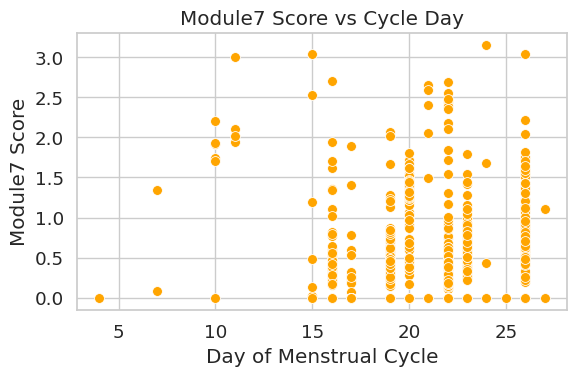

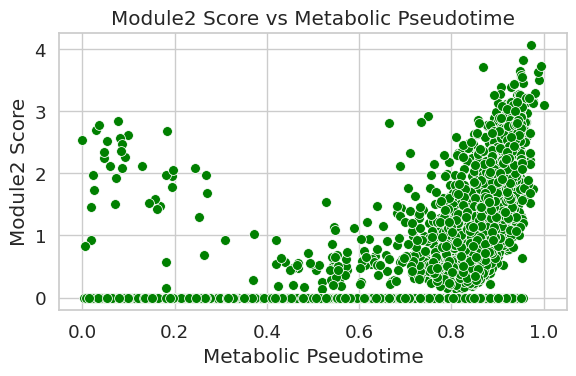

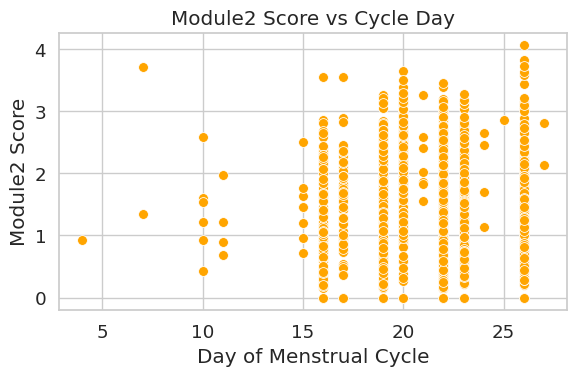

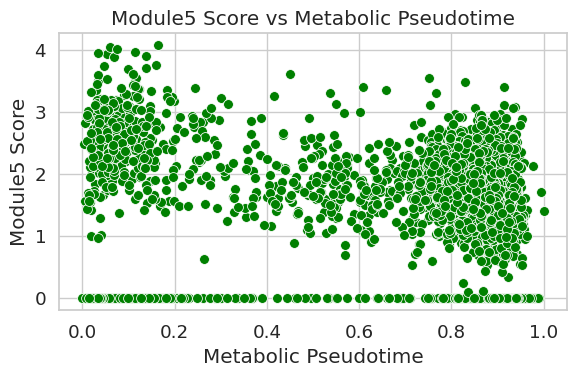

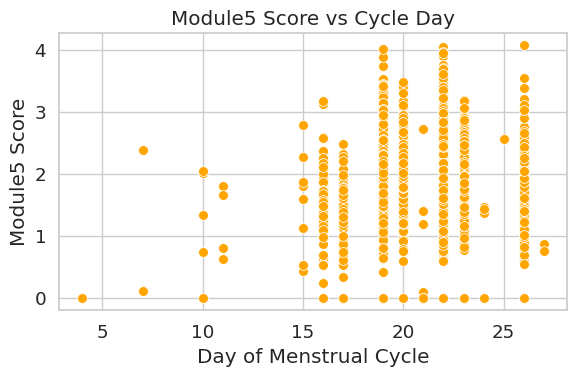

Module1: Spearman correlation with pseudotime = 0.981 (p=0.000e+00); with cycle day = -0.028 (p=6.093e-02)
Module9: Spearman correlation with pseudotime = 0.003 (p=8.575e-01); with cycle day = -0.050 (p=8.408e-04)
Module6: Spearman correlation with pseudotime = -0.152 (p=2.835e-24); with cycle day = -0.022 (p=1.347e-01)
Module3: Spearman correlation with pseudotime = -0.452 (p=4.038e-222); with cycle day = -0.023 (p=1.257e-01)
Module4: Spearman correlation with pseudotime = -0.458 (p=2.494e-229); with cycle day = 0.002 (p=8.963e-01)
Module8: Spearman correlation with pseudotime = -0.140 (p=9.144e-21); with cycle day = 0.022 (p=1.343e-01)
Module7: Spearman correlation with pseudotime = -0.134 (p=2.362e-19); with cycle day = 0.018 (p=2.218e-01)
Module2: Spearman correlation with pseudotime = 0.568 (p=0.000e+00); with cycle day = -0.049 (p=1.167e-03)
Module5: Spearman correlation with pseudotime = -0.293 (p=2.612e-88); with cycle day = -0.071 (p=2.102e-06)


In [7]:
#!/usr/bin/env python
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import scipy.cluster.hierarchy as sch

# Reuse the extended metabolic genes from previous analysis
mt_genes = [gene for gene in ciliated.var_names if gene.startswith('MT-')]
glycolysis_genes = ['GAPDH', 'PKM', 'LDHA', 'ALDOA']
oxphos_genes = ['COX4I1', 'NDUFA9', 'ATP5F1C', 'COX7C']
additional_metabolic = [gene for gene in glycolysis_genes + oxphos_genes if gene in ciliated.var_names]
extended_metabolic_genes = list(set(mt_genes + additional_metabolic))

# Subset the ciliated data to extended metabolic genes
ciliated_metabolic_full = ciliated[:, extended_metabolic_genes].copy()

# Extract expression matrix and convert to dense format if necessary
expr = ciliated_metabolic_full.X
if hasattr(expr, 'toarray'):
    expr = expr.toarray()

# Compute gene-gene Spearman correlation matrix
n_genes = expr.shape[1]
gene_corr = np.zeros((n_genes, n_genes))
for i in range(n_genes):
    for j in range(i, n_genes):
        rho, _ = spearmanr(expr[:, i], expr[:, j])
        gene_corr[i, j] = rho
        gene_corr[j, i] = rho

# Create DataFrame for the correlation matrix
corr_df = pd.DataFrame(gene_corr, index=extended_metabolic_genes, columns=extended_metabolic_genes)

# Visualize hierarchical clustering with a clustermap
clustermap = sns.clustermap(corr_df, cmap='vlag', linewidths=0.5, figsize=(10,10), annot=True)
plt.title('Clustermap of Gene-Gene Spearman Correlations (Metabolic Genes)')
plt.show()

# Convert the correlation matrix to a distance matrix; here using distance = 1 - correlation
distance_matrix = 1 - corr_df
# Ensure the diagonal is zero
distance_matrix.values[np.arange(distance_matrix.shape[0]), np.arange(distance_matrix.shape[0])] = 0

# Compute condensed distance matrix required by linkage
condensed_dist = sch.distance.squareform(distance_matrix.values)

# Perform hierarchical clustering with average linkage
linkage_matrix = sch.linkage(condensed_dist, method='average')

# Dynamically detect clusters using a distance threshold; adjust t as needed
cluster_labels = sch.fcluster(linkage_matrix, t=0.5, criterion='distance')

# Map cluster labels to gene names to define modules
modules = {}
for gene, label in zip(extended_metabolic_genes, cluster_labels):
    mod_name = f'Module{label}'
    if mod_name in modules:
        modules[mod_name].append(gene)
    else:
        modules[mod_name] = [gene]

print('Detected gene modules:')
for mod, genes in modules.items():
    print(f'{mod}: {genes}')

# Calculate module scores: average expression of module genes per cell
for mod_name, gene_list in modules.items():
    valid_genes = [gene for gene in gene_list if gene in ciliated_metabolic_full.var_names]
    if valid_genes:
        sub_expr = ciliated_metabolic_full[:, valid_genes].X
        if hasattr(sub_expr, 'toarray'):
            sub_expr = sub_expr.toarray()
        module_score = np.mean(sub_expr, axis=1)
        ciliated.obs[mod_name + '_score'] = module_score

# Plot module scores versus metabolic pseudotime and cycle day
for mod_name in modules.keys():
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='metabolic_pseudotime', y=mod_name + '_score', data=ciliated.obs, s=50, color='green')
    plt.title(f'{mod_name} Score vs Metabolic Pseudotime')
    plt.xlabel('Metabolic Pseudotime')
    plt.ylabel(f'{mod_name} Score')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    sns.scatterplot(x='day', y=mod_name + '_score', data=ciliated.obs, s=50, color='orange')
    plt.title(f'{mod_name} Score vs Cycle Day')
    plt.xlabel('Day of Menstrual Cycle')
    plt.ylabel(f'{mod_name} Score')
    plt.tight_layout()
    plt.show()

# Compute and print Spearman correlations for each module
for mod_name in modules.keys():
    valid = ciliated.obs[['metabolic_pseudotime', 'day', mod_name + '_score']].dropna()
    if valid.shape[0] > 0:
        rho_pt, p_pt = spearmanr(valid['metabolic_pseudotime'], valid[mod_name + '_score'])
        rho_day, p_day = spearmanr(valid['day'], valid[mod_name + '_score'])
        print(f'{mod_name}: Spearman correlation with pseudotime = {rho_pt:.3f} (p={p_pt:.3e}); with cycle day = {rho_day:.3f} (p={p_day:.3e})')

### Agent Interpretation

The results highlight interesting gene module dynamics in relation to pseudotime and cycle day, with potential implications for endometrial biology:

1. **Module 1 and 2**: These modules, containing mitochondrial genes, show strong correlations with pseudotime (0.981 and 0.568, p=0.000), suggesting these genes may play key roles in cellular metabolism as the cycle progresses. Further investigation could explore how these mitochondrial changes contribute to cellular readiness for processes like decidualization and implantation. 

2. **Module 9 (LDHA)**: Shows minimal correlation with pseudotime (0.003), indicating a stable role across the cycle, but a slight anti-correlation with cycle day (-0.050, p=8.408e-04) could imply specific functions at certain phases. These insights might be valuable to explore further for cycle phase-specific metabolism.

3. **Negative Correlations (Modules 3, 4, 5, 6, 8, 7)**: These modules have various metabolic and canonical glycolytic enzymes showing negative or weak correlations with pseudotime. For instance, GAPDH in Module 4 is anti-correlated with pseudotime but shows no significant correlation with cycle day. The possible transitions between proliferative and secretory phases could be driving these patterns.

4. **Gene-Gene Correlation Clustermap**: It reveals clusters of highly correlated mitochondrial genes, suggesting cooperative functions in energy production and possible modularity in response to pseudotime, supporting metabolic shifts observed. 

### Future Steps:

- **Module Specific Investigations**: Dive deeper into Modules 1 and 2, which show strong correlation with pseudotime, for understanding mitochondrial dynamics in different cellular phases.

- **Phase-specific Expression**: Explore detailed expression patterns of Module 9 to unravel its role in specific phases like WOI or decidualization.

- **Functional Validation**: Perform functional assays (e.g., knockdown or overexpression) on key genes in the highly correlated modules to validate their biological significance within the cycle.

- **Phase Transition Analysis**: Use temporal clustering to verify if these modules contribute to discrete transitions, as seen in the window of implantation.

These insights should enrich the understanding of metabolic states and transitions within the endometrium, distinct from prior research.

## This code computes Spearman correlations between mitochondrial module scores and gene expression in ciliated epithelial cells while caching gene expression vectors to improve performance. It filters for genes showing a positive correlation, selects the top 20, visualizes their expression profiles via a heatmap ordered by metabolic pseudotime, and produces a bar plot annotating each gene's correlation coefficient with its corresponding p-value.

Top 20 genes positively correlated with Module1_score:
MT-ATP6: rho = 0.955, p-value = 0.000e+00
MT-ND4: rho = 0.948, p-value = 0.000e+00
MT-CO2: rho = 0.944, p-value = 0.000e+00
MT-ND1: rho = 0.932, p-value = 0.000e+00
MT-ND5: rho = 0.932, p-value = 0.000e+00
MT-ND3: rho = 0.932, p-value = 0.000e+00
MT-ND2: rho = 0.928, p-value = 0.000e+00
MT-CO3: rho = 0.928, p-value = 0.000e+00
MT-CYB: rho = 0.926, p-value = 0.000e+00
MT-CO1: rho = 0.919, p-value = 0.000e+00
MT-ND4L: rho = 0.793, p-value = 0.000e+00
MALAT1: rho = 0.691, p-value = 0.000e+00
MTRNR2L8: rho = 0.671, p-value = 0.000e+00
NEAT1: rho = 0.628, p-value = 0.000e+00
MT-ATP8: rho = 0.618, p-value = 0.000e+00
MTRNR2L12: rho = 0.569, p-value = 0.000e+00
MT-ND6: rho = 0.524, p-value = 0.000e+00
XIST: rho = 0.489, p-value = 5.504e-266
DNAAF1: rho = 0.479, p-value = 1.160e-253
CFAP70: rho = 0.443, p-value = 8.052e-213


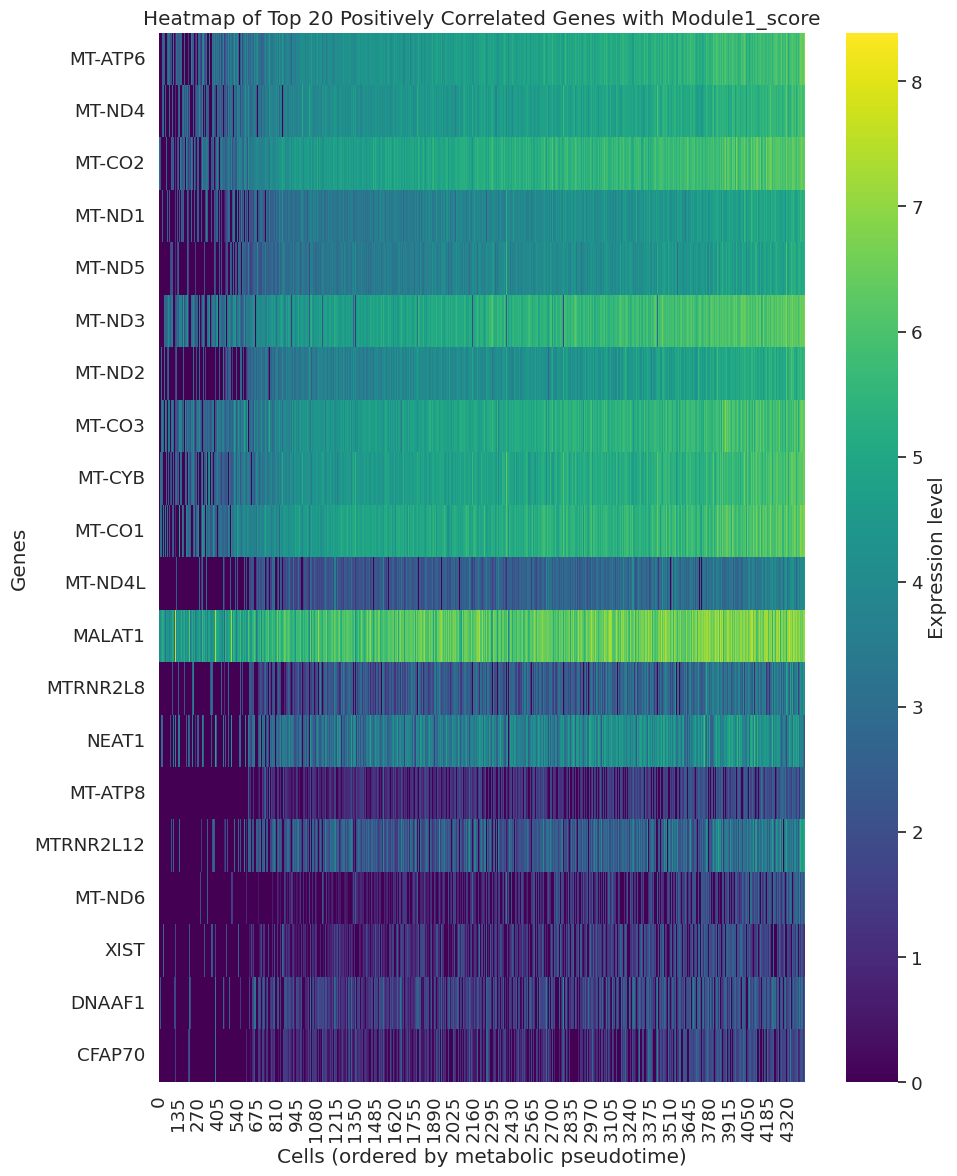

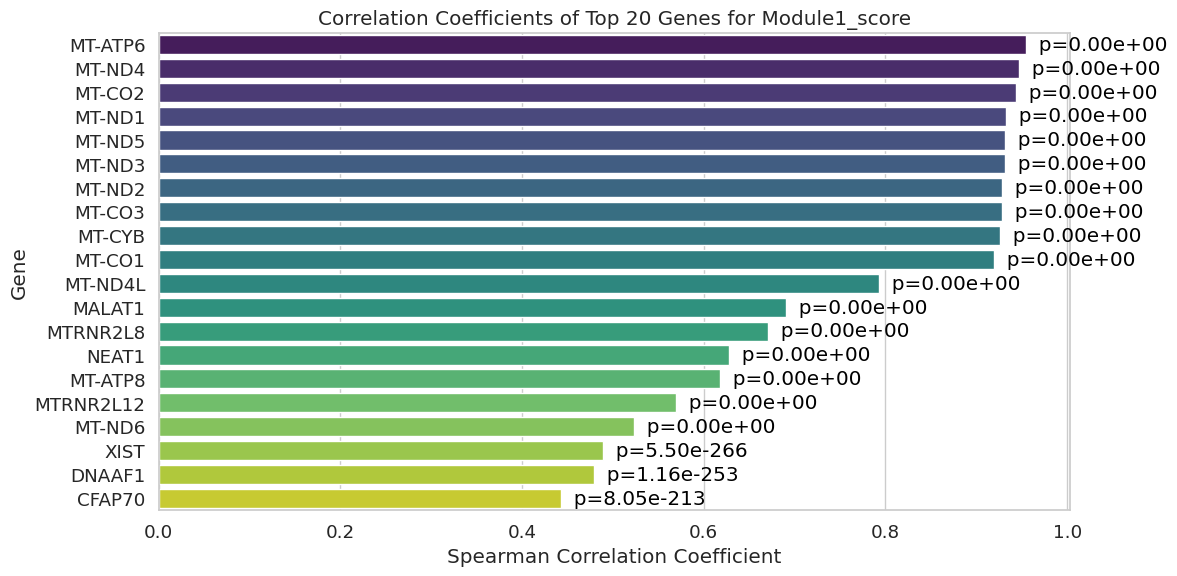

Top 20 genes positively correlated with Module2_score:
MT-ND6: rho = 1.000, p-value = 0.000e+00
MT-CYB: rho = 0.527, p-value = 0.000e+00
MT-ND2: rho = 0.524, p-value = 0.000e+00
MT-ND5: rho = 0.518, p-value = 2.541e-303
MT-CO1: rho = 0.510, p-value = 1.828e-292
MT-ND4: rho = 0.509, p-value = 1.191e-290
MT-ATP6: rho = 0.500, p-value = 2.256e-279
MT-ND1: rho = 0.496, p-value = 1.330e-274
MT-CO3: rho = 0.488, p-value = 9.177e-264
MT-CO2: rho = 0.473, p-value = 9.832e-246
MALAT1: rho = 0.466, p-value = 1.323e-237
MT-ND3: rho = 0.439, p-value = 6.259e-209
MT-ND4L: rho = 0.407, p-value = 2.796e-176
NEAT1: rho = 0.375, p-value = 2.142e-148
MT-ATP8: rho = 0.354, p-value = 2.202e-131
MTRNR2L8: rho = 0.339, p-value = 4.599e-120
CFAP70: rho = 0.334, p-value = 6.125e-116
MTRNR2L12: rho = 0.318, p-value = 1.567e-104
XIST: rho = 0.312, p-value = 4.230e-101
DNAAF1: rho = 0.302, p-value = 5.512e-94


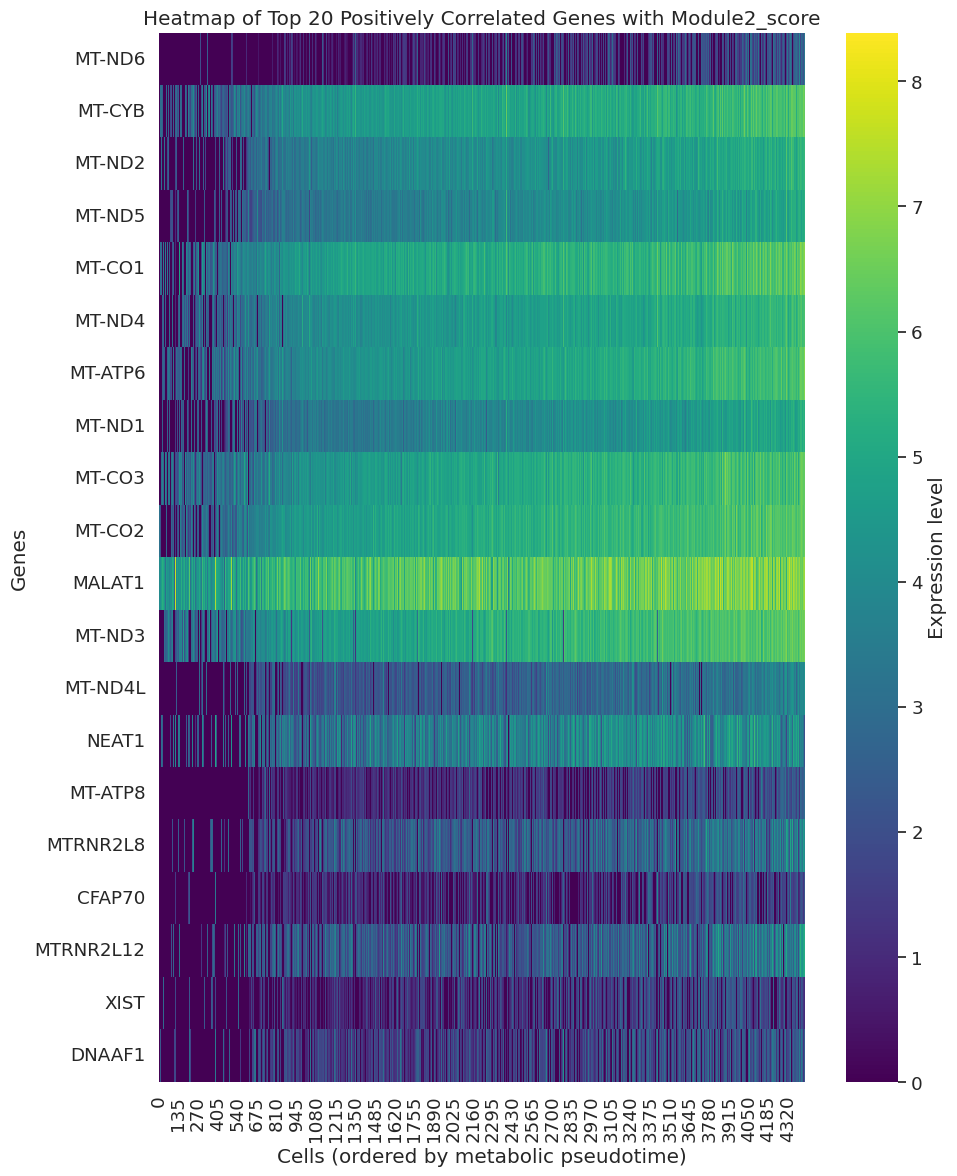

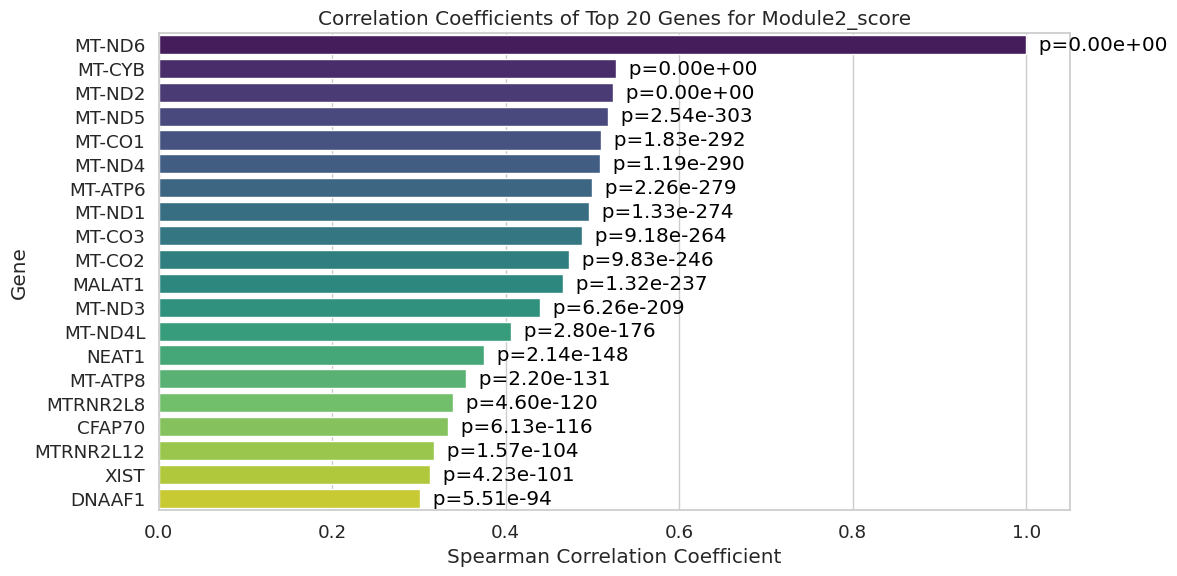

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Define the modules to investigate
modules_to_investigate = ['Module1_score', 'Module2_score']

# Check that metabolic pseudotime exists
if 'metabolic_pseudotime' not in ciliated.obs.columns:
    raise ValueError('metabolic_pseudotime not found in ciliated.obs. Please compute it in a previous step.')

# Order cells by metabolic pseudotime for heatmap visualization
cell_order = np.argsort(ciliated.obs['metabolic_pseudotime'].values)

for mod in modules_to_investigate:
    if mod not in ciliated.obs.columns:
        print(f"Warning: {mod} is not found in ciliated.obs. Skipping...")
        continue

    mod_scores = ciliated.obs[mod].values
    correlations = {}
    expr_cache = {}  # cache gene expression vectors to avoid redundant computation

    # Iterate over all genes in the dataset and cache each gene's expression
    for gene in ciliated.var_names:
        expr = ciliated[:, gene].X
        if hasattr(expr, 'toarray'):
            expr = expr.toarray().flatten()
        else:
            expr = np.array(expr).flatten()
        expr_cache[gene] = expr
        # Compute Spearman correlation between the gene expression and the module score
        rho, pval = spearmanr(expr, mod_scores)
        # Only store genes with a positive correlation to align with the hypothesis
        if rho > 0:
            correlations[gene] = (rho, pval)

    if not correlations:
        print(f"No positively correlated genes found for {mod}.")
        continue

    # Sort genes by Spearman rho in descending order and select top 20
    sorted_genes = sorted(correlations.items(), key=lambda x: x[1][0], reverse=True)
    top_20 = sorted_genes[:20]
    print(f"Top 20 genes positively correlated with {mod}:")
    for gene, (rho, pval) in top_20:
        print(f"{gene}: rho = {rho:.3f}, p-value = {pval:.3e}")

    # Build an expression matrix: rows are genes, columns are cells ordered by metabolic pseudotime
    expr_matrix = []
    gene_names = []
    for gene, _ in top_20:
        expr = expr_cache[gene][cell_order]
        expr_matrix.append(expr)
        gene_names.append(gene)

    expr_df = pd.DataFrame(expr_matrix, index=gene_names)

    # Plot heatmap of the top 20 genes' expression profiles
    plt.figure(figsize=(10, 0.5 * len(gene_names) + 2))
    sns.heatmap(expr_df, cmap='viridis', cbar_kws={'label': 'Expression level'})
    plt.title(f'Heatmap of Top 20 Positively Correlated Genes with {mod}')
    plt.xlabel('Cells (ordered by metabolic pseudotime)')
    plt.ylabel('Genes')
    plt.tight_layout()
    plt.show()

    # Additional visualization: bar plot of correlation coefficients with p-value annotations
    plt.figure(figsize=(12, 6))
    # Extract correlation coefficients and gene names for plotting
    corrs = [item[1][0] for item in top_20]
    gene_names = [item[0] for item in top_20]
    ax = sns.barplot(x=corrs, y=gene_names, palette='viridis')
    plt.xlabel('Spearman Correlation Coefficient')
    plt.ylabel('Gene')
    plt.title(f'Correlation Coefficients of Top 20 Genes for {mod}')
    # Annotate each bar with its corresponding p-value
    for i, (gene, (rho, pval)) in enumerate(top_20):
        ax.text(rho, i, f'  p={pval:.2e}', color='black', va='center')
    plt.tight_layout()
    plt.show()

### Agent Interpretation

The results indicate that mitochondrial genes (MT-genes) are highly correlated with Module1 and Module2 scores, suggesting strong involvement in metabolic processes. Notably, mitochondrial genes dominate the top correlations, which may point to a significant metabolic component in the modules.

**Feedback:**

1. **Metabolic Focus**: The heavy presence of MT-genes suggests mitochondrial activity is a distinguishing feature of these modules. Further analyses could explore the relationship between these modules and metabolic changes during the menstrual cycle, specifically in energy-demanding processes like tissue remodeling.

2. **Non-Mitochondrial Genes**: Genes like MALAT1 and NEAT1, which also show strong correlation with modules, are involved in regulatory processes such as transcriptional regulation and cellular stress responses. Investigating whether these genes play roles in endometrial cell cycle transitions or stress responses during different phases of the cycle might provide insights into endometrial dynamics.

3. **Comparison with the WOI**: Since the WOI is a critical phase marked by transcriptional changes, examining whether the gene modules correlate with markers identified during this phase (like PAEP, GPX3, and CXCL14 from the paper) could validate the functional relevance of these modules.

4. **Cell Type Specificity**: Consider exploring whether these modules are enriched in specific endometrial cell types using existing metadata, as this might reveal cell-type-specific metabolic or regulatory roles and contribute to understanding cellular heterogeneity.

5. **Pathway Analysis**: Performing pathway enrichment analyses (such as gene ontology or KEGG pathway enrichment) using genes in both modules could identify overrepresented biological processes and pathways, providing a broader context to the gene correlations observed.

6. **Pseudotime Analysis**: Building on the pseudotime analysis used in the original paper, you might employ similar techniques to order cells along a cycle- or phase-related trajectory to directly link module expression to menstrual cycle phases. 

7. **Technical Validation**: Given the high correlations and significant p-values, ensuring technical validation across different datasets (e.g., cross-validating with datasets used in the study) would strengthen the findings.

These steps should help determine whether the hypothesis regarding the role of these gene modules in the endometrial cycle is supported and offer new biological insights distinct from the original study.